In [2]:
# Import des bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import duckdb
import requests
from tqdm import tqdm
import seaborn as sns
from cartiflette import carti_download
import os
from shapely.geometry import shape
from prettytable import PrettyTable

This is an experimental version of cartiflette published on PyPi.
To use the latest stable version, you can install it directly from GitHub with the following command:
pip install git+https://github.com/inseeFrLab/cartiflette.git


# Préparation des données

In [3]:
# Téléchargement des fichiers (s'ils ne sont pas déjà enregistrés) et affichage d'une barre de progression
def download_file(url: str, filename: str) -> None:
    try:
        # Envoyer une requête GET à l'URL
        response = requests.get(url, stream=True)
        
        # Vérifier si la requête a réussi
        response.raise_for_status()
        
        # Récupérer la taille totale du fichier depuis les headers (si disponible)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 Kilobyte

        # Afficher un message si le content-length n'est pas disponible
        if total_size == 0:
            print(f"Impossible de déterminer la taille du fichier {filename}, téléchargement sans barre de progression.")
        
        # Configuration de la barre de progression
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=filename) if total_size > 0 else None
        
        # Écrire le contenu dans le fichier
        with open(filename, 'wb') as file:
            for chunk in response.iter_content(chunk_size=block_size):
                if progress_bar:
                    progress_bar.update(len(chunk))
                file.write(chunk)
        
        if progress_bar:
            progress_bar.close()
        print(f"Fichier téléchargé avec succès: {filename}")
    
    except requests.exceptions.RequestException as e:
        print(f"Le téléchargement a échoué: {e}")

# Liste des URLs avec les noms personnalisés des fichiers à télécharger
files_to_download = {
    "logements": {"url": "https://static.data.gouv.fr/resources/recensement-de-la-population-fichiers-detail-logements-ordinaires-en-2020-1/20231023-123618/fd-logemt-2020.parquet", "filename": "RP_logements_2020.parquet"},
    "individus": {"url": "https://static.data.gouv.fr/resources/recensement-de-la-population-fichiers-detail-individus-localises-au-canton-ou-ville-2020-1/20231023-122841/fd-indcvi-2020.parquet", "filename": "RP_individus_2020.parquet"},
    "documentation_logement": {"url": "https://www.data.gouv.fr/fr/datasets/r/c274705f-98db-4d9b-9674-578e04f03198", "filename": "Dictionnaire_RP_logements_2020.csv"},
    "documentation_individus": {"url": "https://www.data.gouv.fr/fr/datasets/r/1c6c6ab2-b766-41a4-90f0-043173d5e9d1", "filename": "Dictionnaire_RP_individus_2020.csv"},
    "table_bpe": {"url": "https://www.insee.fr/fr/statistiques/fichier/8217525/BPE23.parquet", "filename": "BPE_2023.parquet"}
}

# Boucle pour télécharger les fichiers avec des noms personnalisés (s'ils ne sont pas déjà enregistrés)
for key, file_info in files_to_download.items():
    url = file_info["url"]
    filename = file_info["filename"]
    
    # Débogage : vérifier si le fichier existe déjà
    if os.path.exists(filename):
        print(f"Le fichier {filename} existe déjà, pas de téléchargement.")
    else:
        print(f"Téléchargement de {filename}...")
        download_file(url, filename)


Téléchargement de RP_logements_2020.parquet...


RP_logements_2020.parquet: 100%|██████████| 504M/504M [00:23<00:00, 21.6MiB/s] 


Fichier téléchargé avec succès: RP_logements_2020.parquet
Téléchargement de RP_individus_2020.parquet...


RP_individus_2020.parquet: 100%|██████████| 533M/533M [00:24<00:00, 21.4MiB/s] 


Fichier téléchargé avec succès: RP_individus_2020.parquet
Téléchargement de Dictionnaire_RP_logements_2020.csv...
Impossible de déterminer la taille du fichier Dictionnaire_RP_logements_2020.csv, téléchargement sans barre de progression.
Fichier téléchargé avec succès: Dictionnaire_RP_logements_2020.csv
Téléchargement de Dictionnaire_RP_individus_2020.csv...
Impossible de déterminer la taille du fichier Dictionnaire_RP_individus_2020.csv, téléchargement sans barre de progression.
Fichier téléchargé avec succès: Dictionnaire_RP_individus_2020.csv
Téléchargement de BPE_2023.parquet...
Impossible de déterminer la taille du fichier BPE_2023.parquet, téléchargement sans barre de progression.
Fichier téléchargé avec succès: BPE_2023.parquet


In [6]:
# Connexion à DuckDB (les tables seront stockées dans la RAM)
con = duckdb.connect()

# Chargement des tables dans (et donc accessibles via) DuckDB
con.execute("""
    CREATE OR REPLACE VIEW table_logement AS 
    SELECT * FROM read_parquet('RP_logements_2020.parquet')
""")
con.execute("""
    CREATE OR REPLACE VIEW table_individu AS 
    SELECT * FROM read_parquet('RP_individus_2020.parquet')
""")

documentation_logement = pd.read_csv("Dictionnaire_RP_logements_2020.csv", sep=';')
documentation_individus = pd.read_csv("Dictionnaire_RP_individus_2020.csv", sep=';')

In [7]:
# IMPORT DES DONNEES DE FOND DE CARTE AU NIVEAU DEPARTEMENT

departements = carti_download(
    values=["France"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# Bar chart: la pyramide des âges

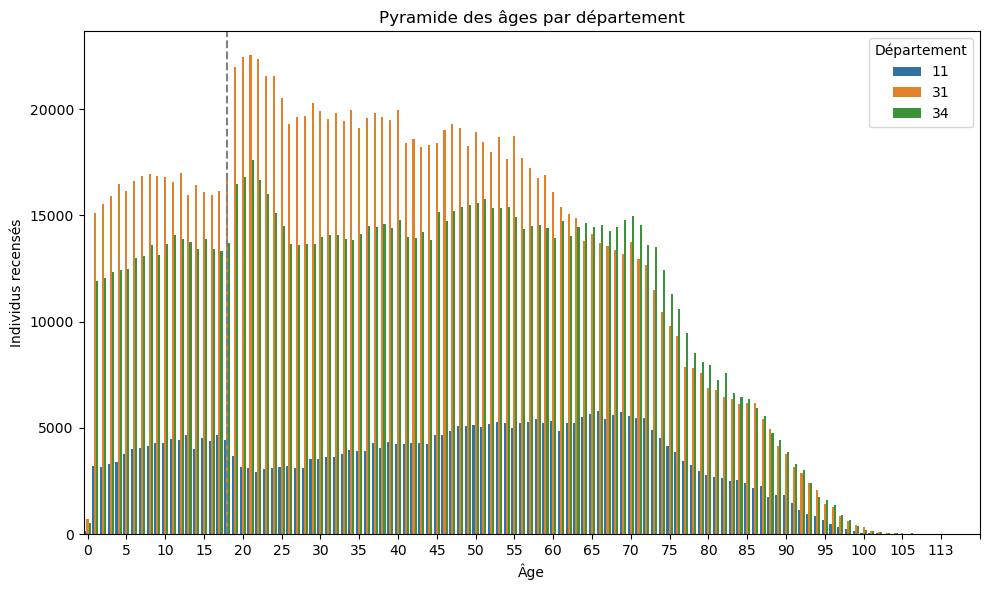

In [8]:
# Requête SQL pour constuire une table agrégées par âge x département
query = """
    SELECT AGED, DEPT AS departement, SUM(IPONDI) AS individus
    FROM table_individu
    WHERE DEPT IN ('11', '31', '34')
    GROUP BY AGED, DEPT
    ORDER BY DEPT, AGED
"""

# Exécuter la requête via DuckDB et collecter les résultats dans un DataFrame pandas
pyramide_ages = con.execute(query).df()

# Visualisation avec matplotlib et seaborn (équivalent ggplot2)
plt.figure(figsize=(10, 6))
sns.barplot(data=pyramide_ages, x='AGED', y='individus', hue='departement')

# Ajouter une ligne verticale pour marquer l'âge de 18 ans
plt.axvline(x=18, color='grey', linestyle='--')

# Modifier les labels de l'axe des x pour qu'ils apparaissent tous les 5 ans
age_ticks = range(0, pyramide_ages['AGED'].max() + 1, 5)  # Intervalles de 5 ans
plt.xticks(ticks=age_ticks)

# Paramètres de la figure
plt.title("Pyramide des âges par département")
plt.xlabel("Âge")
plt.ylabel("Individus recensés")
plt.legend(title="Département")
plt.tight_layout()

# Afficher la figure
plt.show()


# Carte : Répartition des plus de 60 ans par département

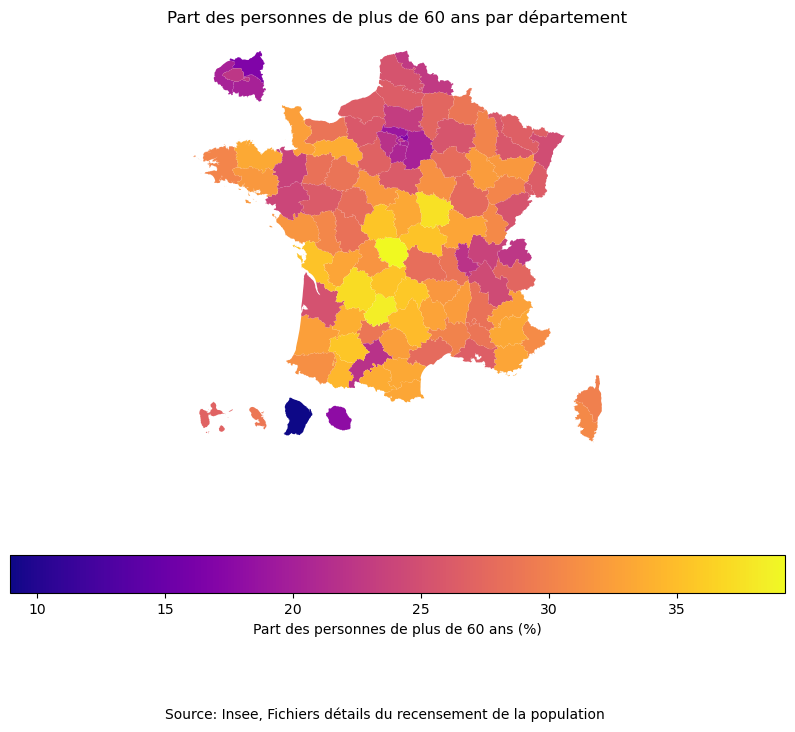

In [9]:
# Requête SQL pour calculer la part de la population de plus de 60 ans par département
query = """
    SELECT DEPT, 
           SUM(IPONDI) AS total_population, 
           SUM(CASE WHEN AGED > 60 THEN IPONDI ELSE 0 END) AS population_60_plus
    FROM table_individu
    GROUP BY DEPT
"""

# Exécuter la requête et récupérer les résultats dans un DataFrame pandas
part_population_60_plus = con.execute(query).df()

# Calcul du pourcentage de population de plus de 60 ans
part_population_60_plus['pourcentage_60_plus'] = (part_population_60_plus['population_60_plus'] / 
                                                  part_population_60_plus['total_population']) * 100

 # Joindre les données de population avec la carte des départements (GeoDataFrame)
departements_60_plus_sf = departements.merge(part_population_60_plus, 
                                             left_on="INSEE_DEP", 
                                             right_on="DEPT")

# Création de la carte
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Légende et choix de la palette 
departements_60_plus_sf.plot(column='pourcentage_60_plus', 
                             ax=ax, 
                             legend=True, 
                             cmap='plasma',  
                             legend_kwds={'label': "Part des personnes de plus de 60 ans (%)",
                                          'orientation': "horizontal"})

# Ajout du titre et de la source
plt.title("Part des personnes de plus de 60 ans par département")
plt.figtext(0.5, 0.02, "Source: Insee, Fichiers détails du recensement de la population", ha="center")
plt.axis('off')  # Retirer les axes pour une meilleure visualisation

# Affichage de la carte
plt.show()                                                 

# Cartes : parts des résidences seconaires et des logements vacants par département

In [10]:
# Requête SQL pour comptabiliser les résidences principales et secondaires
query = """
    SELECT 
        CASE WHEN substr(COMMUNE, 1, 3) = '97' THEN substr(COMMUNE, 1, 3)
             ELSE substr(COMMUNE, 1, 2) 
        END AS DEPT, 
        CATL, 
        SUM(IPONDL) AS n
    FROM table_logement
    GROUP BY DEPT, CATL
"""

# Exécuter la requête et récupérer les résultats dans un DataFrame pandas
parc_locatif = con.execute(query).df()

# Jointure avec le fond de carte des départements (GeoDataFrame)
parc_locatif_sf = departements.merge(parc_locatif, 
                                     left_on="INSEE_DEP", 
                                     right_on="DEPT")

# Calcul de la part des différentes catégories dans le parc locatif
parc_locatif_sf['p'] = parc_locatif_sf.groupby('INSEE_DEP')['n'].transform(lambda x: x / x.sum())


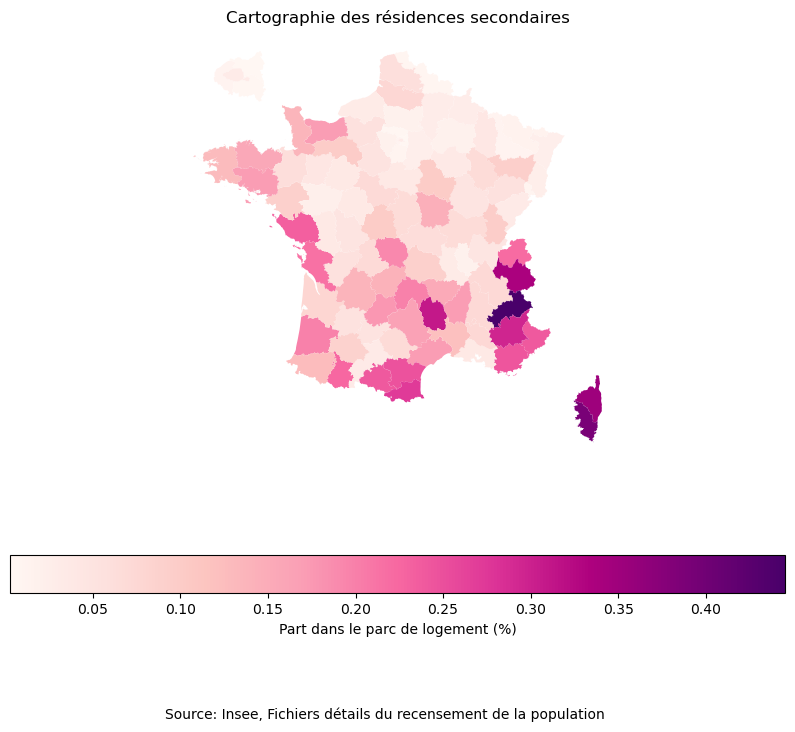

In [11]:
# Création de la carte des résidences secondaires (CATL == "3")
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Légende et choix de la palette 
parc_locatif_sf[parc_locatif_sf['CATL'] == '3'].plot(column='p', 
                                                     ax=ax, 
                                                     legend=True, 
                                                     cmap='RdPu',  
                                                     legend_kwds={'label': "Part dans le parc de logement (%)",
                                                                  'orientation': "horizontal"})

# Ajout du titre et de la source
plt.title("Cartographie des résidences secondaires")
plt.figtext(0.5, 0.02, "Source: Insee, Fichiers détails du recensement de la population", ha="center")
plt.axis('off')  # Retirer les axes pour une meilleure visualisation

# Affichage de la carte des résidences secondaires
plt.show()

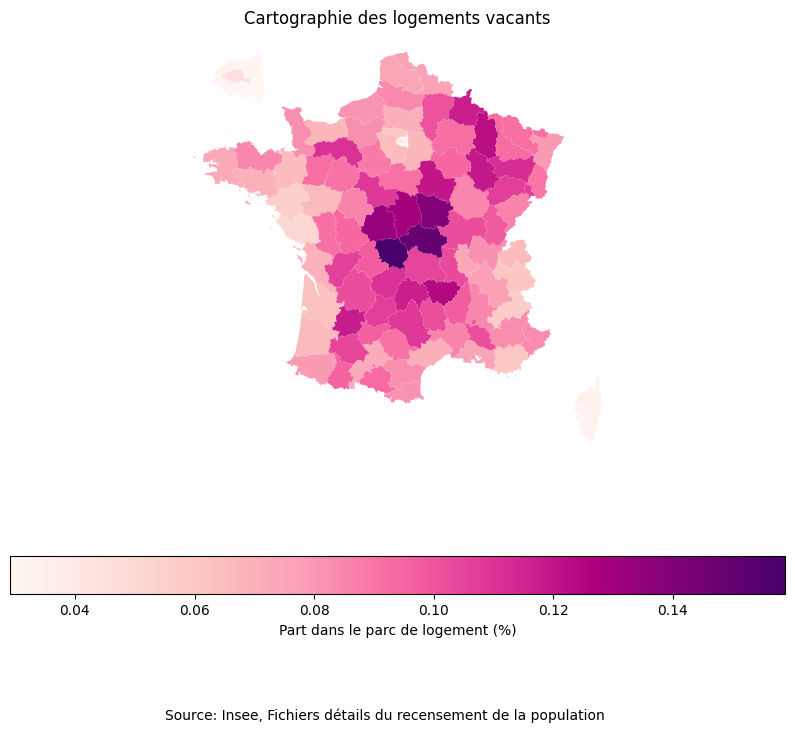

In [16]:
# Création de la carte des logements vacants (CATL == "4")
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Légende et choix de la palette 
parc_locatif_sf[parc_locatif_sf['CATL'] == '4'].plot(column='p', 
                                                     ax=ax, 
                                                     legend=True, 
                                                     cmap='RdPu',  # Utilise la même palette 'RdPu'
                                                     legend_kwds={'label': "Part dans le parc de logement (%)",
                                                                  'orientation': "horizontal"})

# Ajout du titre et de la source
plt.title("Cartographie des logements vacants")
plt.figtext(0.5, 0.02, "Source: Insee, Fichiers détails du recensement de la population", ha="center")
plt.axis('off')  # Retirer les axes pour une meilleure visualisation

# Affichage de la carte des logements vacants
plt.show()

# Graphique: MODE DE TRANSPORT x AGE

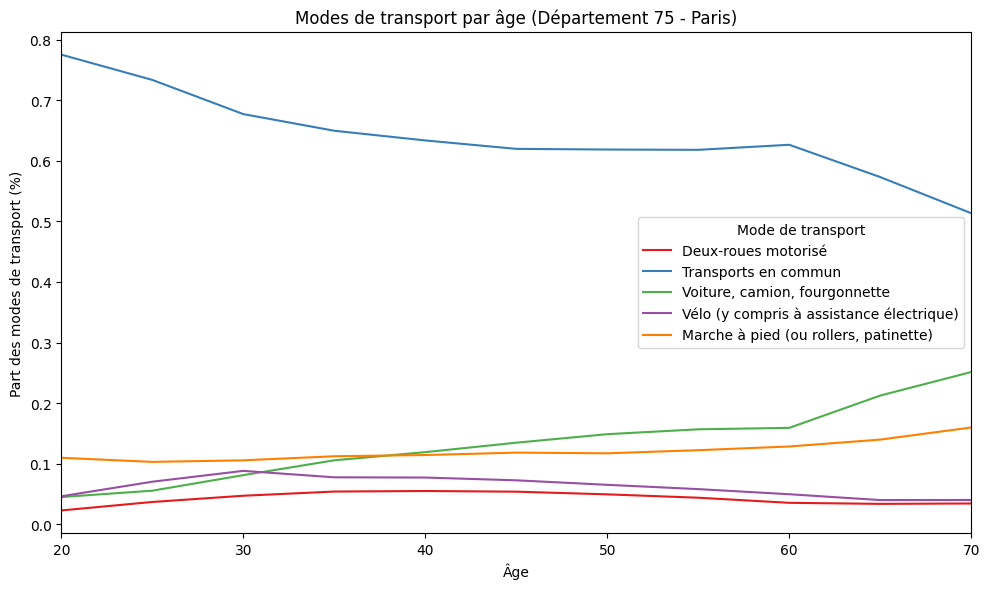

In [29]:
# Requête SQL pour calculer les modes de transport principaux par département et âge
query = """
    SELECT 
        CASE WHEN substr(DEPT, 1, 3) = '97' THEN substr(DEPT, 1, 3)
             ELSE substr(DEPT, 1, 2) 
        END AS DEPT, 
        AGEREVQ, 
        TRANS, 
        SUM(IPONDI) AS n
    FROM table_individu
    WHERE TRANS NOT IN ('1', 'Z')  -- Exclure les valeurs non pertinentes pour le transport
    GROUP BY DEPT, AGEREVQ, TRANS
"""

# Exécuter la requête et récupérer les résultats dans un DataFrame pandas
transports_age = con.execute(query).df()

# Calcul de la part des modes de transport par âge et département
transports_age['p'] = transports_age.groupby(['DEPT', 'AGEREVQ'])['n'].transform(lambda x: x / x.sum())

# Filtrer les données pour le département de Paris (DEPT == '75')
transports_age = transports_age[transports_age['DEPT'] == '75']

# Convertir la colonne AGEREVQ en variable numérique
transports_age['AGEREVQ'] = pd.to_numeric(transports_age['AGEREVQ'], errors='coerce')

# Ajout du libellé du mode de transport à partir d'une autre table (documentation_individus)
# On suppose que `documentation_individus` est déjà chargé en tant que DataFrame pandas
transports_age = transports_age.merge(documentation_individus[documentation_individus['COD_VAR'] == 'TRANS'],
                                      left_on='TRANS', right_on='COD_MOD', how='inner')

# Visualisation avec matplotlib et seaborn
plt.figure(figsize=(10, 6))

# Tracer une courbe pour chaque mode de transport avec Seaborn
sns.lineplot(data=transports_age, 
             x='AGEREVQ', 
             y='p', 
             hue='LIB_MOD',  # Utiliser les libellés des modes de transport
             palette='Set1')

# Ajuster les limites de l'axe des x
plt.xlim(20, 70)

# Ajouter des étiquettes et un titre
plt.xlabel('Âge')
plt.ylabel('Part des modes de transport (%)')
plt.title('Modes de transport par âge (Département 75 - Paris)')
plt.legend(title='Mode de transport')

# Afficher le graphique
plt.tight_layout()
plt.show()


# Tableau: statistiques descriptives

In [31]:
# Requête SQL pour calculer la part de la population de plus de 60 ans par département
query_population_60_plus = """
    SELECT DEPT, 
           SUM(IPONDI) AS total_population, 
           SUM(CASE WHEN AGED > 60 THEN IPONDI ELSE 0 END) AS population_60_plus
    FROM table_individu
    GROUP BY DEPT
"""
part_population_60_plus = con.execute(query_population_60_plus).df()
part_population_60_plus['pourcentage_60_plus'] = (part_population_60_plus['population_60_plus'] / 
                                                  part_population_60_plus['total_population']) * 100

# Résidences secondaires
part_residences_secondaires = parc_locatif[parc_locatif['CATL'] == '2'].groupby('DEPT')['n'].sum().reset_index()
part_residences_secondaires['pourcentage_residences_secondaires'] = (
    part_residences_secondaires['n'] / part_residences_secondaires['n'].sum()) * 100

# Logements vacants
part_logements_vacants = parc_locatif[parc_locatif['CATL'] == '4'].groupby('DEPT')['n'].sum().reset_index()
part_logements_vacants['pourcentage_logements_vacants'] = (
    part_logements_vacants['n'] / part_logements_vacants['n'].sum()) * 100

# Calculer les statistiques descriptives : moyenne, min, max pour chaque variable
statistiques_descriptives = pd.DataFrame({
    'variable': ["Part des 60 ans et plus (%)", "Part des résidences secondaires (%)", "Part des logements vacants (%)"],
    'moyenne': [
        part_population_60_plus['pourcentage_60_plus'].mean(),
        part_residences_secondaires['pourcentage_residences_secondaires'].mean(),
        part_logements_vacants['pourcentage_logements_vacants'].mean()
    ],
    'minimum': [
        part_population_60_plus['pourcentage_60_plus'].min(),
        part_residences_secondaires['pourcentage_residences_secondaires'].min(),
        part_logements_vacants['pourcentage_logements_vacants'].min()
    ],
    'maximum': [
        part_population_60_plus['pourcentage_60_plus'].max(),
        part_residences_secondaires['pourcentage_residences_secondaires'].max(),
        part_logements_vacants['pourcentage_logements_vacants'].max()
    ]
})



In [34]:
# Générer la table avec PrettyTable
table_stats_desc = PrettyTable()
table_stats_desc.field_names = ["Variable", "Moyenne", "Min", "Max"]

# Ajouter les lignes dans la table
for i, row in statistiques_descriptives.iterrows():
    table_stats_desc.add_row([row['variable'], 
                              f"{row['moyenne']:.1f}", 
                              f"{row['minimum']:.1f}", 
                              f"{row['maximum']:.1f}"])

# Afficher la table formatée
print(table_stats_desc)


+-------------------------------------+---------+-----+------+
|               Variable              | Moyenne | Min | Max  |
+-------------------------------------+---------+-----+------+
|     Part des 60 ans et plus (%)     |   28.7  | 8.9 | 39.2 |
| Part des résidences secondaires (%) |   1.0   | 0.1 | 13.5 |
|    Part des logements vacants (%)   |   1.0   | 0.1 | 4.3  |
+-------------------------------------+---------+-----+------+


In [37]:
print(statistiques_descriptives)

                              variable    moyenne   minimum    maximum
0          Part des 60 ans et plus (%)  28.725644  8.929144  39.216636
1  Part des résidences secondaires (%)   1.030928  0.098491  13.456022
2       Part des logements vacants (%)   1.030928  0.128592   4.250629
